In [145]:
%load_ext autoreload
%aimport processing, basket, coin

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
%autoreload 1

import pandas as pd
import numpy as np

import datetime
from datetime import timezone
import pytz

from pycoingecko import CoinGeckoAPI

from processing import Processor
from basket import Basket
from coin import Coin

In [120]:
cg = CoinGeckoAPI()

In [121]:
# coin_list = cg.get_coins_list()

# ids = [coin_data['id'] for coin_data in coin_list]

# id_to_data = {}
# for coin_data in coin_list:
#     id_to_data[coin_data.pop('id')] = coin_data
# ids = id_to_data.keys()

In [122]:
# COIN_COLS = ['id', 'symbol', 'name']
# df_coin_names = pd.DataFrame(coin_list, columns=['name'])

# coin_market = cg.get_coins_markets(vs_currency=NAT_CURR)
# df_market = pd.DataFrame(coin_market, columns=['id', 'current_price', 'high_24h', 'low_24h'])
# df_market.set_index('id', inplace=True)

In [123]:
###############
## CONSTANTS ##
###############

NAT_TZ = 'America/Los_Angeles'
NAT_TZOBJ = pytz.timezone(NAT_TZ)

TRG_TZOBJ = timezone.utc

PORT_IDS = ['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']

NAT_CURR = 'usd'

LOOKBACKS = [7, 14, 30]
ROLL_WIND = LOOKBACKS[1]

In [124]:
##################
## LOCAL DRIVER ##
##################

start_date, end_date = (2020,1,1), (2021,10,31)

processor = Processor(cg)

# Create portfolio dataframe
port_val = processor.create_portfolio(PORT_IDS, start_date, end_date)
prices = processor.data

processor.normalize([], port=True)

### Testing cointegration of crypto basket
Test cointegration of coin basket: {coins} = {c_1,...,c_n}
ie. Check that the set {coins} is cointegrated using Engle-Granger two-step test
This means there is some STATIONARY linear combination of {coins}

<ol>
    <li>Check that c_i is order-1 integrable</li>
    <li>Create basket of coins, find linear regression.</li>
    <li>Verify spread of basket is cointegrated.</li>
    <li>Define strategy for basket trades.</li>
</ol>

#### Concerns
<ul>
    <li>Should we normalize data before running our regression?</li>
</ul>

#### Conclusions
<ul>
    <li>OLS and Linear Regression yield the same coefficients</li>
    <li>While we usually assume stock data is I(1), it sometimes isn't (eg. Litecoin, BTC-Cash)</li>
    <li>Normalization might help us find a regression line that does cointegrate the portfolio</li>
    <li>We should run this test on different coins in different sized baskets.</li>
</ul>

Verifying coin price stationarity...
bitcoin is I(1)
bitcoin-cash is I(1)
ethereum is I(1)
litecoin is I(1)
Basket is valid, all coins are I(1).
Fitting linear_regression ...
Found coefficients for basket:  [1, -66.41456935145989, 6.317443097671282, 340.54675533260354]
At intercept:  8199.409989048654
Cointegration test returned: True


<Figure size 432x288 with 0 Axes>

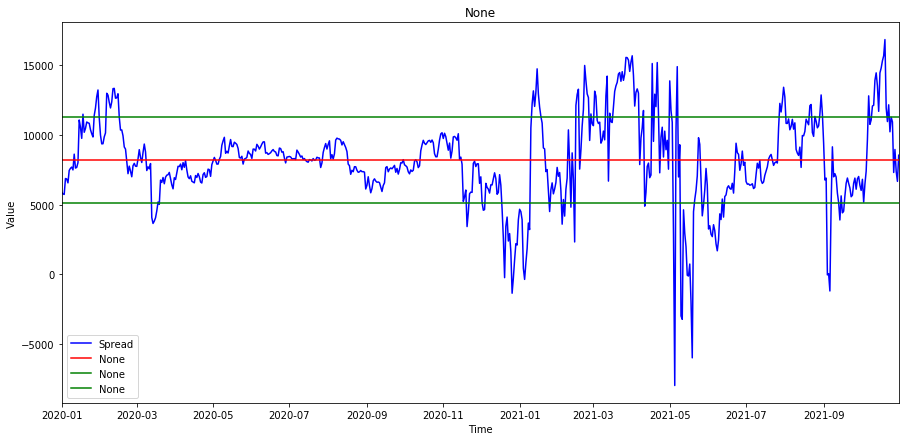

In [153]:
############
## TEST 1 ##
############

# print("Normalizing...")
# scaler = MinMaxScaler()
# scaler.fit(X, y)
# X_scaled = scaler.transform(X) # TODO: Finish normalization
# X_scaled = pd.DataFrame(X_scaled/X_scaled[0], index=X.index) 
# X_scaled.columns = X.columns

print("Verifying coin price stationarity...")
coins = []
for coin_name in data:
    coin = Coin(coin_name, processor)
    result = coin.is_good(prices[coin_name], start_date, end_date)
    if result:
        print(coin_name, "is I(1)")
        coins.append(coin)
    else:
        print(coin_name, "is not I(1)")

basket = Basket(coins, target='bitcoin', processor=processor)
basket.is_valid()
basket.fit(prices)
spread = basket.find_spread(prices)
is_cointegrated = basket.is_coint(spread)

print("Cointegration test returned:", is_cointegrated)

short_entry, long_entry = basket.strat(spread)

<Figure size 432x288 with 0 Axes>

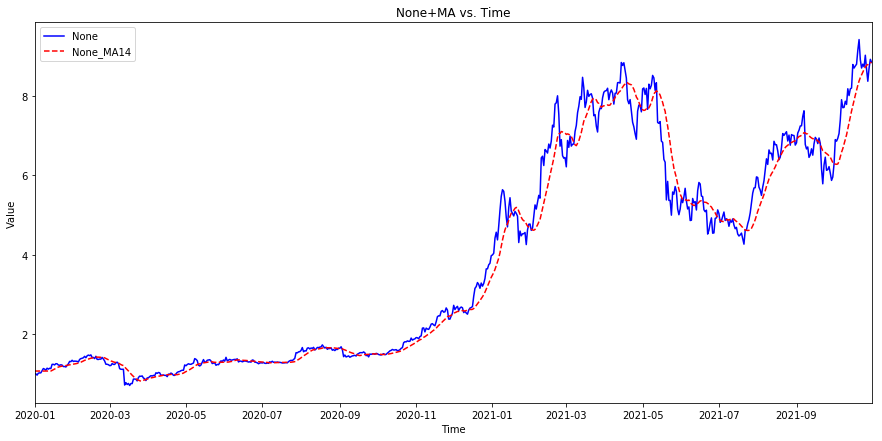

t-stat = -14.989087081532297: The series None_RM_I is stationary with confidence level  99%
(-15.00975490743259, 9.013998115919061e-27, array([-3.91288546, -3.34527843, -3.05079569]))


In [126]:
############
## TEST 2 ##
############

# Create normalized timeseries for portfolio
port_rm = processor.take_roll_avg(ROLL_WIND)
port_rm.name = f'{port_val.name}_RM'


# IF a random variable is stationary THEN it is also order one integratable #

port_ret = processor.integrate(port_rm)

comparator = port_ret + np.random.normal(0, 5, len(port_ret))

# These two series should be stationary and cointegrate
coint_res = processor.is_coint(port_ret, comparator)
print(coint_res)

<Figure size 432x288 with 0 Axes>

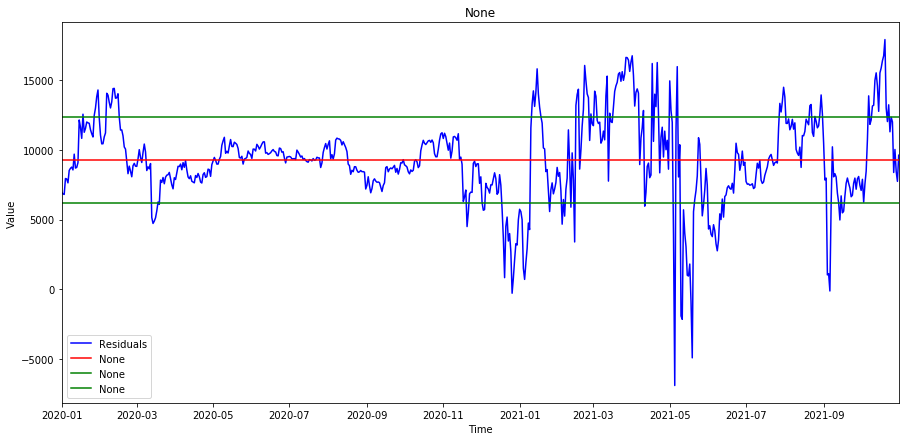

In [40]:
processor.plot_series([residuals, spread_mean, upper_band, lower_band], colors=['blue', 'red', 'green', 'green'])

In [ ]:
############
## TEST 3 ##
############

d_1, d_2 = processor.id_to_prices(cg, PORT_IDS[0], start_date, end_date), processor.id_to_prices(cg, PORT_IDS[1], start_date, end_date)
s_1, s_2 = pd.Series(d_1), pd.Series(d_2)
s_1.name, s_2.name = PORT_IDS[0], PORT_IDS[1]

# Random two series likely should not be stationary
coint_res = processor.is_coint(s_1, s_2)
print(coint_res)

In [ ]:
# processor.take_mean(s_1)
# df_feats = processor.series_to_df_feats(s_1, LOOKBACKS, plot=True)

# print(processor.sharpe_ratio(df_feats[f'{s_1.name}_DR']))
